# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

## Result summary

### Condition 1 (EM->GW)

Steps:
1. Sample GRB detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GRB detectable events, how many are detectable in GWs.

I will consider sub-threshold events as detectable (snr>6).

| Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GRB | 11535.4 | 9.16 | 1:1259.32 |
| GW(snr>8) | 2.29 | 4.12e-3 | 1:555.82 |
| ratio[GW(snr>8)/GRB] | 1:5031.45 | 1:2222.22 | - |
| GW(snr>6) | 4.35 | 9.8e-3 | 1:443.88 |
| ratio[GW(snr>6)/GRB] | 1:2649 | 1:934.58 | - |

### Condition 2 (GW->EM)

Steps:
1. Sample GW detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GW detectable events, how many are detectable in GRBs.

I will consider super-threshold events only (snr>8).

| Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GW(snr>8) | 20 | 4.86e-2 | 1:411.52 |
| GRB (associated) | 1.82 | 3.93e-3 | 1:463.10 |
| ratio[GRB/GW(snr>8)] | 1:11 | 1:12.36 | - |
| GW(snr>6) | 46.8 | 1.36e-1 | 1:344.12 |
| GRB (associated) | 4.38 | 9.66e-3 | 1:453.42 |
| ratio[GRB/GW(snr>6)] | 1:10.68 | 1:14.11 | - |

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [118]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [119]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [120]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [128]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [122]:
# class initialization
grb = GRB()

In [123]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [124]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [125]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

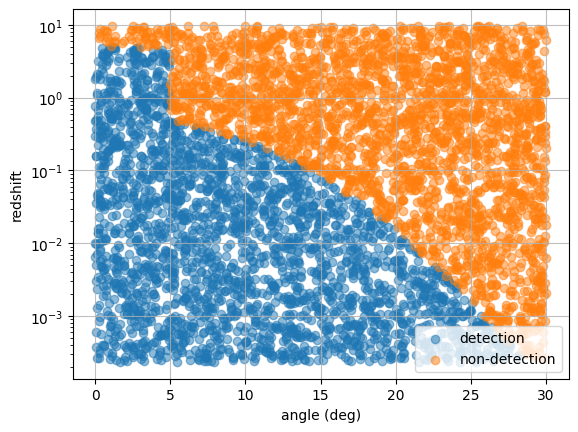

In [126]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

In [132]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

### Unlensed events

In [134]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb3.json",
    meta_data_file="meta_unlensed_grb3.json",
)

collected number of detectable events =  0
collected number of detectable events =  5034
total number of events =  200000
total unlensed rate (yr^-1): 11502.021876934157
collected number of detectable events =  10130
total number of events =  400000
total unlensed rate (yr^-1): 11572.85276254897
collected number of detectable events =  15024
total number of events =  600000
total unlensed rate (yr^-1): 11442.615327708832
collected number of detectable events =  20042
total number of events =  800000
total unlensed rate (yr^-1): 11448.327495903575
collected number of detectable events =  25024
total number of events =  1000000
total unlensed rate (yr^-1): 11435.30375241956
collected number of detectable events =  30259
total number of events =  1200000
total unlensed rate (yr^-1): 11522.966493648215
collected number of detectable events =  35426
total number of events =  1400000
total unlensed rate (yr^-1): 11563.386883826252
collected number of detectable events =  40493
total number o

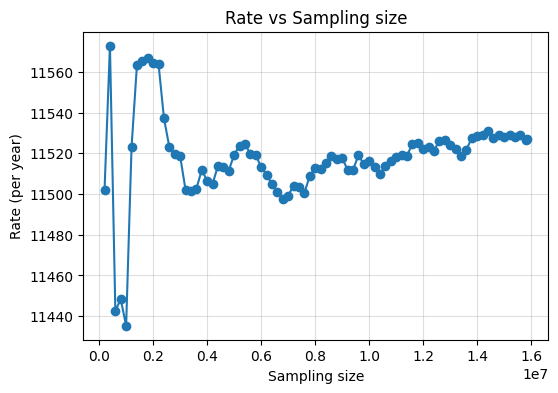

In [140]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb3.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [142]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1.4e7)[0]
# take average 
grb_rate_unlensed1 = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed1)

Unlensed GRB Rate (per year) = 11528.482182495489


### Checking how many of these events are detectable in GWs

In [143]:
# gwsnr will be used to calculate the SNR of the associated GW event
ler = LeR(
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [144]:
# get the generated unlensed parameters
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb3.json")
# calculate the SNR of the associated GW event
snr_unlensed = ler.snr(gw_param_dict=unlensed_param_detectable)['optimal_snr_net']

In [145]:
# super-threshold only
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>8)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>8)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>8)}")

Number of unlensed detectable events in terms of GW snr is 75 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11528.482182495489, 
then the rate of detectable GWs is 2.161590409217904

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 5333.333333333333


In [146]:
# sub-threshold considered
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>6)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>6)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>6)}")

Number of unlensed detectable events in terms of GW snr is 147 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11528.482182495489, 
then the rate of detectable GWs is 4.2367172020670925

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 2721.08843537415


### Lensed events

In [147]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [153]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb3.json",
    meta_data_file="meta_lensed_grb3.json",
)

collected number of detectable events =  50000


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of detectable events =  52128
total number of events =  4971561.0
total lensed rate (yr^-1): 10.50521697787832


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of detectable events =  54246
total number of events =  5171561.0
total lensed rate (yr^-1): 10.509276165500378


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


collected number of detectable events =  56337
total number of events =  5371561.0
total lensed rate (yr^-1): 10.507997031160349


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


collected number of detectable events =  58489
total number of events =  5571561.0
total lensed rate (yr^-1): 10.517779049317003


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of detectable events =  60576
total number of events =  5771561.0
total lensed rate (yr^-1): 10.515599544209637


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


collected number of detectable events =  62684
total number of events =  5971561.0
total lensed rate (yr^-1): 10.51708940066161


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of detectable events =  64757
total number of events =  6171561.0
total lensed rate (yr^-1): 10.512800713703424


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.11it/s]


collected number of detectable events =  66828
total number of events =  6371561.0
total lensed rate (yr^-1): 10.508466773140004


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of detectable events =  68941
total number of events =  6571561.0
total lensed rate (yr^-1): 10.510799985921844


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95it/s]


collected number of detectable events =  70951
total number of events =  6771561.0
total lensed rate (yr^-1): 10.497755718397203


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


collected number of detectable events =  73134
total number of events =  6971561.0
total lensed rate (yr^-1): 10.510322264426517


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  75200
total number of events =  7171561.0
total lensed rate (yr^-1): 10.505842374478075


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  77266
total number of events =  7371561.0
total lensed rate (yr^-1): 10.501605574965886


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of detectable events =  79394
total number of events =  7571561.0
total lensed rate (yr^-1): 10.505796741282563


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


collected number of detectable events =  81467
total number of events =  7771561.0
total lensed rate (yr^-1): 10.502681619198784


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of detectable events =  83535
total number of events =  7971561.0
total lensed rate (yr^-1): 10.499094384013164


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  85601
total number of events =  8171561.0
total lensed rate (yr^-1): 10.495437527268672


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of detectable events =  87691
total number of events =  8371561.0
total lensed rate (yr^-1): 10.494827709585559


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


collected number of detectable events =  89784
total number of events =  8571561.0
total lensed rate (yr^-1): 10.49459701110926


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of detectable events =  91912
total number of events =  8771561.0
total lensed rate (yr^-1): 10.498374603740627


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.19it/s]


collected number of detectable events =  94026
total number of events =  8971561.0
total lensed rate (yr^-1): 10.500420311220797


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


collected number of detectable events =  96190
total number of events =  9171561.0
total lensed rate (yr^-1): 10.50783882156901


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of detectable events =  98303
total number of events =  9371561.0
total lensed rate (yr^-1): 10.509488326964753


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of detectable events =  100413
total number of events =  9571561.0
total lensed rate (yr^-1): 10.51075487304043
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb3.json
storing meta data in ./ler_data/meta_lensed_grb3.json

 trmming final result to size=100000
collected number of detectable events =  100000
total number of events =  9532193.0
total unlensed rate (yr^-1): 10.510754920160904


In [191]:
# lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb3.json")
# zs = lensed_param_detectable['zs']
# viewing_angle = lensed_param_detectable['theta_jn']
# # radian to degree
# viewing_angle = np.degrees(viewing_angle)
# # if angle > 90, then angle = 180 - angle
# viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

# # blue: detection, red: non-detection
# plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# # draw a horizontal line for GW170817, 40Mpc
# # plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

# plt.xlabel("viewing angle (deg)")
# plt.ylabel("redshiift")
# plt.yscale("log")
# plt.legend()
# plt.grid(alpha=0.8)
# plt.show()

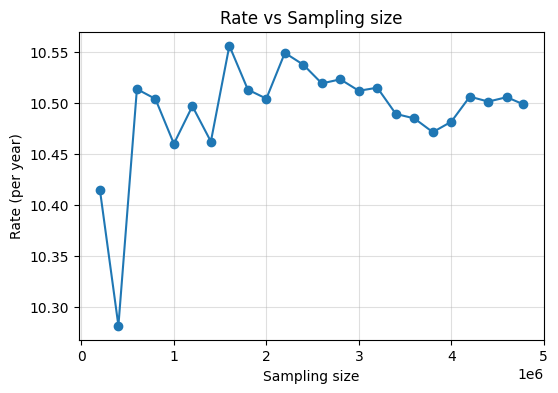

In [152]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb3.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [156]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_lensed1 = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed1)

Lensed GRB Rate (per year) = 10.4946943371119


### Out of the detected GRB events, how many are detectable in GW.

* find out GW detector SNRs of the event which are detectable in GRBs.

* check how many of them cross the SNR threshold

In [172]:
# ler initialization with default snr calculator (gwsnr)
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [173]:
# get snr for the lensed events
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb3.json")
snr_lensed, _ = ler.get_lensed_snrs(lensed_param_detectable, list_of_detectors=['L1','H1','V1'], snr_calculator=ler.snr)
snr_lensed = snr_lensed['optimal_snr_net']

In [174]:
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 42 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.4946943371119, 
then the rate of detectable GWs is 0.0044077716215869985

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 2380.9523809523807


In [175]:
# sub-threshold events considered
num_ =  np.sum(np.sum(snr_lensed>6, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 92 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.4946943371119, 
then the rate of detectable GWs is 0.009655118790142948

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 1086.9565217391305


### Detector horizon calculation for BNS

In [176]:
from gwsnr import GWSNR
gwsnr = GWSNR(
    mtot_max=51,
    ifos=['L1','H1','V1'],
    gwsnr_verbose=False,
)

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_4.pickle


In [177]:
dhor = gwsnr.detector_horizon(mass_1=1.4, mass_2=1.4, snr_th_net=6)['net'][0]
print(f"Detector Horizon for BNS at SNR=6 is {dhor} Mpc")

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]

dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]
Detector Horizon for BNS at SNR=6 is 2137.345241875989 Mpc


## Plot (GRB with associated GW)

In [178]:
# This will be used to plot the viewing angle vs redshift
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb3.json")
zs_grb_unlensed = unlensed_param_detectable['zs']
viewing_angle_grb_unlensed = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_unlensed = np.degrees(viewing_angle_grb_unlensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90] = viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90]-90

In [183]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb3.json")
zs_grb_lensed = lensed_param_detectable['zs']
viewing_angle_grb_lensed = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_lensed = np.degrees(viewing_angle_grb_lensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90] = viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90]-90

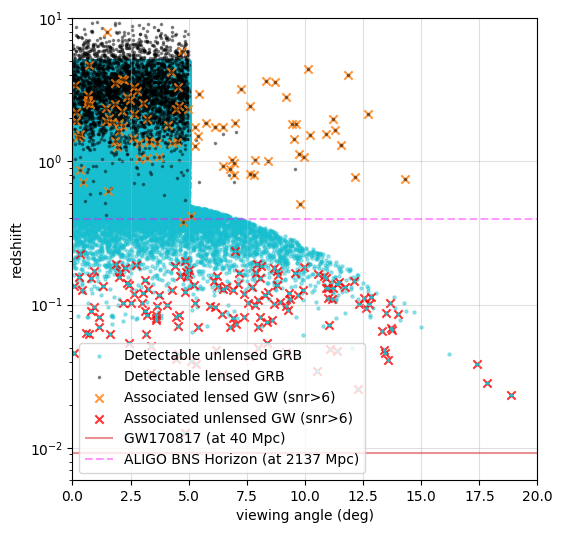

In [212]:
# blue: detection, red: non-detection
num_ = np.round(len(viewing_angle_grb_lensed)/30)
idx_ = np.random.choice(len(viewing_angle_grb_lensed), int(num_), replace=False)

plt.figure(figsize=(6,6))

# unlensed GRB
plt.scatter(viewing_angle_grb_unlensed, zs_grb_unlensed, c='C9', label="Detectable unlensed GRB", alpha=0.4, marker='.', s=20)

# lensed GRB
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', label="Detectable lensed GRB", alpha=0.4, marker='.', s=10)

# lensed GW, only snr_lensed>6
idx_ = np.sum(snr_lensed>6, axis=1)>=2
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='C1', label="Associated lensed GW (snr>6)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', alpha=0.4, marker='.', s=10)

# unlensed GW, only snr_unlensed>6
idx_ = snr_unlensed>6
plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='r', label="Associated unlensed GW (snr>6)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='C9', alpha=0.9, marker='.', s=10)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=0, xmax=20, colors='C3', linestyles='solid', label='GW170817 (at 40 Mpc)', alpha=0.5)

# dhor 
plt.hlines(y=grb.dl_to_z(dhor), xmin=0, xmax=20, colors='magenta', linestyles='dashed', label="ALIGO BNS Horizon (at 2137 Mpc)", alpha=0.4)

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
#plt.title("Detectable GRB vs associated detectable GW")
plt.yscale("log")
plt.xlim(0., 20)
plt.ylim(0.006, 10)
plt.legend(loc='lower left')
plt.grid(alpha=0.4)
plt.show()